In [7]:
import numpy as np
import tifffile
from scipy import ndimage
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops


file_name = f"/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/tif_deneme_1.tif"

img = tifffile.imread(file_name)  # (Z, C, Y, X)
print(img.shape)

# Sadece 4. kanalı (C3, index 3) tüm Z-stack ile al
channel_index = 3
c3_stack = img[:, channel_index, :, :]  # Shape: (9, 1024, 1024)

print(c3_stack.shape)


(9, 4, 1024, 1024)
(9, 1024, 1024)


z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


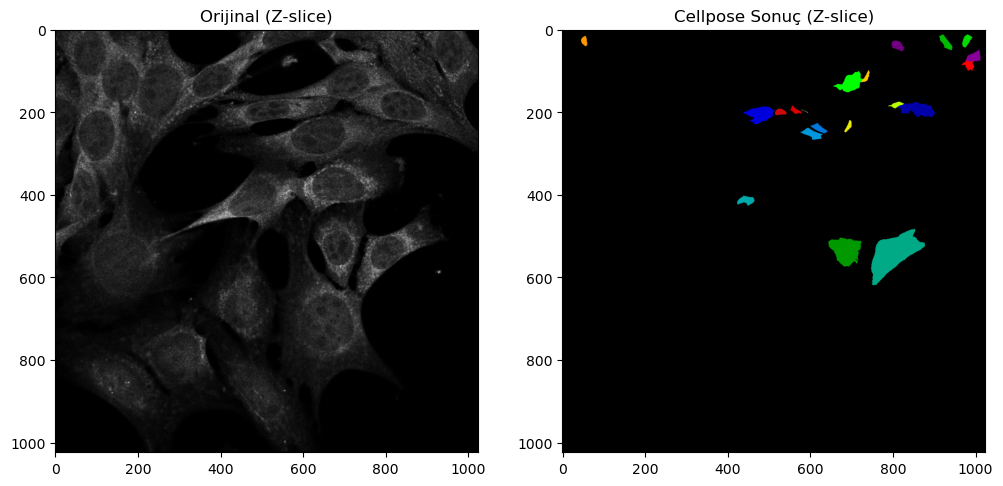

In [11]:
from cellpose import models, io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Cellpose modelini büyük hücreler için yükle
model = models.Cellpose(model_type='cyto')  # veya nuclei, ama büyük hücreler için cyto genellikle daha iyi

# Normalize ve filtrele
stack_normalized = (c3_stack - np.min(c3_stack)) / (np.max(c3_stack) - np.min(c3_stack))
stack_scaled = (stack_normalized * 255).astype(np.uint8)
stack_filtered = gaussian_filter(stack_scaled, sigma=1)  # Gürültü bastırılır

# Segmentasyon (manuel diameter ve yüksek min_size ile)
masks, flows, styles, diams = model.eval(
    stack_filtered,
    channels=[0, 0],
    do_3D=True,
    diameter=120,    # büyük hücreler için örnek çap değeri (gözle ölçüp ayarla)
    min_size=2000,   # küçük segmentleri eleyerek gereksiz maskeleri temizle
    stitch_threshold=0.1 # buyuk seyleri parcalamasin
)

# Görselleştirme
z_index = len(masks) // 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(stack_scaled[z_index], cmap='gray')
plt.title('Orijinal (Z-slice)')

plt.subplot(1, 2, 2)
plt.imshow(masks[z_index], cmap='nipy_spectral')
plt.title('Cellpose Sonuç (Z-slice)')
plt.show()

# Iteration 1
# diameter=80,    # büyük hücreler için örnek çap değeri (gözle ölçüp ayarla)
# min_size=1500,   # küçük segmentleri eleyerek gereksiz maskeleri temizle


In [12]:
# Maske sonuçlarını kaydet (.tif formatında)
output_mask_path = "/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/cellpose_mask_c3.tif"
tifffile.imwrite(output_mask_path, masks.astype(np.uint16))
print(f"Maskeler kaydedildi: {output_mask_path}")


Maskeler kaydedildi: /Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/cellpose_mask_c3.tif


In [10]:
# 3D regionprops ile hücrelerin özelliklerini hesapla
labeled_mask = label(masks)  # skimage'in 3D label fonksiyonu

regions = regionprops(labeled_mask)

print(f"{len(regions)} hücre bulundu.\n")

# İlk 5 hücre için örnek bilgileri yazdır
for i, region in enumerate(regions[:5]):
    print(f"Hücre {i+1}:")
    print(f"- Hacim (voxel): {region.area}")
    print(f"- Centroid (Z, Y, X): {region.centroid}")
    print(f"- Bounding box: {region.bbox}")
    print()


28 hücre bulundu.

Hücre 1:
- Hacim (voxel): 3681.0
- Centroid (Z, Y, X): (4.877207280630263, 39.14398261342026, 810.6538983971747)
- Bounding box: (0, 28, 796, 9, 60, 834)

Hücre 2:
- Hacim (voxel): 3993.0
- Centroid (Z, Y, X): (4.958677685950414, 67.05910343100426, 1001.0267968945655)
- Bounding box: (0, 49, 977, 9, 86, 1014)

Hücre 3:
- Hacim (voxel): 16703.0
- Centroid (Z, Y, X): (6.011135724121416, 197.426270729809, 867.7649524037598)
- Bounding box: (0, 168, 805, 9, 228, 919)

Hücre 4:
- Hacim (voxel): 14877.0
- Centroid (Z, Y, X): (5.064663574645426, 206.15130738724204, 474.3208980305169)
- Bounding box: (0, 180, 428, 9, 231, 516)

Hücre 5:
- Hacim (voxel): 3250.0
- Centroid (Z, Y, X): (5.468615384615385, 241.6716923076923, 616.4944615384616)
- Bounding box: (0, 227, 591, 9, 258, 644)

